# Hyper-parameter tuning using Bayesian optimization

Bayesian hyperparameter optimization: 
Builds a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.
(https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
(https://github.com/fmfn/BayesianOptimization/blob/master/examples/advanced-tour.ipynb)

We are now using normalized graph laplacians and a gaussian kernel for the weight matrix

## Functions needed to compute u*

In [1]:
# Parameters that are fixed (manually chosen)
g = 0.5 #Noise standard deviation
n_eig = 20
alpha = 1

In [2]:
import autograd.numpy as np
from scipy.linalg import fractional_matrix_power

# Functions for construction of problem

# Assume Noise i.i.d. logistic random variables with mean 0
def cap_psi(X, g):
    # g - gamma
    # cdf of zero-mean logistic random var
    return np.reciprocal(np.exp(-1.0/g*X)+1.0)

def psi(X,g):
    # g - gamma
    # pdf of zero-mean logistic random var
    return 1.0/g*np.exp(-1.0/g*X)*np.reciprocal(np.exp(-1.0/g*X)+1)**2

# Weight function returned by kernel Function
# Gaussian Kernel
def weight(X, N_lst, sigma):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    sigma - parameter for K(x) = exp(-x^2/(2*sigma^2))
    '''
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    N = N_lst.size
    W = np.zeros((N,N))
    for count_i,i in enumerate(N_lst):
        for count_j, j in enumerate(N_lst):
            # kappa function as L2 norm
#             X_i = X[i]; X_j = X[j]
#             dist = 0.0
#             for ix in range(X_i.size):
#                 dist += (X_i[ix]-X_j[ix])**2
            dist_sq = np.linalg.norm(X[i]-X[j])**2
            W[count_i][count_j] = np.exp(-dist_sq/(2.*sigma**2))
    return W

# Inverse of covariance
def Cov_inv(X, N_lst, alpha, tau, sigma):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    sigma - parameter for K(x) = exp(-x^2/(2*sigma^2))
    '''
    N = N_lst.size
    W = weight(X, N_lst, sigma)
    D = np.diag(W.sum(axis=1))
    # D^{-1/2} matrix
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    L = D_inv_sqrt@(D - W)@D_inv_sqrt
    return fractional_matrix_power(1/tau**2*(L + tau**2*np.eye(N)), alpha).real

# truncated version of Covariance defined in [3]-(62)
def Cov_truncated(X, N_lst, alpha, tau, sigma, n_eig):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    sigma - parameter for K(x) = exp(-x^2/(2*sigma^2))
    '''
    N = N_lst.size
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    W = weight(X, N_lst, sigma)
    D = np.diag(W.sum(axis=1))
    # D^{-1/2} matrix
    D = np.diag(W.sum(axis=1))
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    L = D_inv_sqrt@(D - W)@D_inv_sqrt
    LE, LV = np.linalg.eig(L)

    CE = 1/tau**2*(LE + tau**2)**alpha
    C = np.zeros((N,N))
    for k in range(n_eig):
        C = C + 1/CE[k]*np.outer(LV[:,k],(LV[:,k].T))
    return C.real

In [3]:
import ray
from ray import tune
from ray.tune.suggest.bayesopt import BayesOptSearch

# -----------Newton's Method----------------------------------

def misfit(u, N_lst, y, Z_p, g):
    '''
    Misfit function defined in [3]-(45)
    u - vector to find
    N_lst - list of indices used
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    S = 0.0
    for Z_j in Z_p:
        u_j = np.where(N_lst == Z_j)
        S = S - np.log(cap_psi(y[Z_j]*u[u_j][0],g))
    return S

def param_probit_min(X, N_lst, y, Z_p, u, alpha, tau, sigma):

    if type(N_lst) == int:
        N_lst = np.arange(N_lst)

    C_inv = Cov_inv(X, N_lst, alpha, tau, sigma)
    # Minimizer u for problem defined in [3]-(3)
    ret = 1/2*np.dot(u, np.matmul(C_inv,u)) + misfit(u, N_lst, y, Z_p, g)
    return ret

In [4]:
import scipy.optimize
import autograd.numpy as np
import autograd

# ------ EL method ------------------
# Array given by Fj in [3] - (12), (13)
def F_sum(N_lst, g, y, Z_p, u):
    '''
    N_lst - list of indices used
    g - gamma
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    N = N_lst.size
    Fj = np.zeros(N)
    for Z_j in Z_p:
        u_j = np.where(N_lst == Z_j)
        basis=np.zeros(N);basis[u_j]=1.0
        Fj = Fj + y[Z_j]*psi(y[Z_j]*u[u_j], g)/cap_psi(y[Z_j]*u[u_j], g)*basis
    return Fj

# Function needed for fsolve using EL given in [3]-(2)
def u_ast_EL(X, N_lst, y, Z_p, g, alpha, tau, sigma, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    x_0 - initial u_0 to minimize (if undefined, x_0 = vector of zeros)
    '''
    if type(N_lst) == int:
        N_lst = np.arange(N_lst)

    N = N_lst.size
    if x_0: x_0 = np.zeros((N,1))
    n_eig = 20 #[3]-(62) truncation
    C = Cov_truncated(X, N_lst, alpha, tau, sigma, n_eig)
    def final(u):
    #     C = Cov(X, N, eps, alpha, tau, rval)
        return u - C@F_sum(N_lst, g, y, Z_p, u)
    return scipy.optimize.fsolve(final, x_0)

# ------- Newton's method --------------
def newton(f, x0, tol=10e-08, maxiter=50):
    '''
    f - input function
    x0 - initialization
    tol - tolerance for step size
    '''
    g = autograd.grad(f)
    h = autograd.hessian(f) # add small perturbation (black magic)

    x = x0
    for _ in range(maxiter):
        step = np.linalg.solve(h(x), -g(x))
        x = x + step
        if np.linalg.norm(step) < tol:
            break

    return x

# Returns u* using newton's method
def u_ast_Newt(X, N_lst, y, Z_p, g, alpha, tau, sigma, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N) (ex. for full N, N_lst = np.arange(N))
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    '''
    if type(N_lst) == int:
        N_lst = np.arange(N_lst)

    C_inv = Cov_inv(X, N_lst, alpha, tau, sigma)
    def probit_min(u):
        # Minimizer u for problem defined in [3]-(3)
        return 1/2*np.dot(u, C_inv@u) + misfit(u, N_lst, y, Z_p, g)
    if x_0: x_0 = np.zeros(N_lst.size)
    return newton(probit_min, x_0)

# Now using bayesian optimization with kernel-flow methods

In [5]:
# Using Kernel Flow method to approximate parameters

# Return randomly selected half data indices from N that includes half of
# labeled data
# Follows from [1]
def select_Nf(N, Z_prime):
    '''
    N - (int) number of elements
    Z_prime - indices of labeled data
    '''
    N_f = int((N-Z_prime.size)/2) # Must be <= N
    half_Z = int(Z_prime.size/2+1) # half of labels

    # Randomly selected indices N_f and N_c used for X,Y,Z
    # Always need to include Z' or else cant compute
    N_f_i = np.random.choice(N, N_f, replace=False)
    Z_half= np.random.choice(Z_prime, half_Z, replace=False)
    for z in Z_half:
        if z not in N_f_i:
            N_f_i = np.append(N_f_i, z)

    N_f = N_f_i.size
    return N_f_i, Z_half

# alpha = 1.0
# Follows rho expression given in [2]-(6)
def rho_EL(tau, sigma):
    '''
    theta - parameters to optimize (g, alpha, tau, eps, rval)
    X - whole data (not just half)
    N - (int) number of elements
    Z_prime - indices of labeled data
    y - labels (of Z_prime)
    '''
    # g = 0.15; alpha = 1.; tau = 1.;
    # eps, rval= theta

    N_f_i, Z_half = select_Nf(N, Z_prime)
    uast = u_ast_EL(Data, N, y, Z_prime, g, alpha, tau, sigma)
    uast_tild = u_ast_EL(Data, N_f_i, y, Z_half, g, alpha, tau, sigma)

    # Compute |uast-uast_tild|^2/|uast|^2 using L2 norm
    # loop over each valid N_f_i
    num = 0.0
    denom = 0.0
    for u_i, nf_i in enumerate(N_f_i):
        num += (uast_tild[u_i] - uast[nf_i])**2
        denom += uast[nf_i]**2
    return - num/denom

# Follows rho expression given in [2]-(6)
def rho_Newt(tau, sigma):

    '''
    theta - parameters to optimize (g, alpha, tau, eps, rval)
    X - whole data (not just half)
    N - (int) number of elements
    Z_prime - indices of labeled data
    y - labels (of Z_prime)
    '''
    # g = 0.15; alpha = 1.; tau = 1.;
    # eps, rval= theta

    N_f_i, Z_half = select_Nf(N, Z_prime)
    uast = u_ast_Newt(Data, N, y, Z_prime, g, alpha, tau, sigma)
    uast_tild = u_ast_Newt(Data, N_f_i, y, Z_half, g, alpha, tau, sigma)

    # Compute |uast-uast_tild|^2/|uast|^2 using L2 norm
    # loop over each valid N_f_i
    num = 0.0
    denom = 0.0
    for u_i, nf_i in enumerate(N_f_i):
        num += (uast_tild[u_i] - uast[nf_i])**2
        denom += uast[nf_i]**2
    return - num/denom

In [6]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure
from time import perf_counter

def results(Data, y, N, Z_prime, pbounds):
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    plt.scatter(Data[:, 0], Data[:, 1], c=y, cmap=cm_bright, edgecolors="k")
    plt.title('Full Data')
    plt.show()
    plt.scatter(Data[Z_prime, 0], Data[Z_prime, 1], c=y[Z_prime], cmap=cm_bright, edgecolors="k")
    plt.title('Labels given')
    plt.show()
    zeros = 1e-3
    optimizer_EL = BayesianOptimization(
        f=rho_EL,
        pbounds=pbounds,
        verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )
    print("Optimizer for Euler-Lagrange equations")
    # flip (rho) minimize --> (- rho) maximize
    optimizer_EL.maximize(
        init_points=3,
        n_iter=10,
    )
    print(optimizer_EL.max['params'])

    optimizer_Newt = BayesianOptimization(
        f=rho_Newt,
        pbounds=pbounds,
        verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )
    print("Optimizer for Newton's Method")
    # flip (rho) minimize --> (- rho) maximize
    optimizer_Newt.maximize(
        init_points=3,
        n_iter=10,
    )
    print(optimizer_Newt.max['params'])

    # Initial Parameters
    sigma1 = optimizer_EL.max['params']['sigma']
    tau1 = optimizer_EL.max['params']['tau']


    time_start = perf_counter()
    u_ast = u_ast_EL(Data, N, y, Z_prime, g, alpha, tau1, sigma1)
    print("Runtime for EL: " + str(perf_counter() - time_start))
    pred_error =  round(sum(abs(np.sign(u_ast) - np.sign(u_dagger)))/(2*N)*100, 3)
    print("Error for EL: " + str(pred_error))


    tau2 = optimizer_Newt.max['params']['tau']
    sigma2 = optimizer_Newt.max['params']['sigma']
    time_start = perf_counter()
    u_ast_newt = u_ast_Newt(Data, N, y, Z_prime, g, alpha, tau2, sigma2)
    print("Runtime for Newton's: " + str(perf_counter() - time_start))
    pred_error2 =  round(sum(abs(np.sign(u_ast_newt) - np.sign(u_dagger)))/(2*N)*100,3)
    print("Error for Newton's: " + str(pred_error2))

    fig, axs = plt.subplots(3)

    axs[0].scatter(Data[:, 0], Data[:, 1], c=y, cmap=cm_bright, edgecolors="k")
    axs[0].set_title('Correct Lables')

    axs[1].scatter(Data[:, 0], Data[:, 1], c=np.sign(u_ast), cmap=cm_bright, edgecolors="k")
    axs[1].set_title('Best Euler-Lagrange | tau: {:.3f} | alpha : {:.3f} | sigma: {:.3f} | error: {}%'.format(tau1,alpha,sigma1, pred_error))

    axs[2].scatter(Data[:, 0], Data[:, 1], c=np.sign(u_ast_newt), cmap=cm_bright, edgecolors="k")
    axs[2].set_title('Best Newton\'s | tau: {:.3f} | alpha : {:.3f} | sigma: {:.3f} error: {}%'.format(tau2,alpha,sigma2, pred_error2))


    fig.set_size_inches(10, 18)


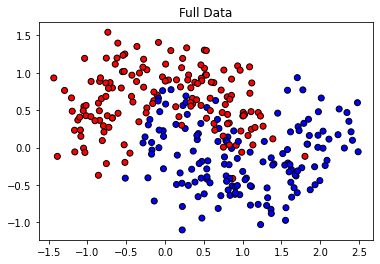

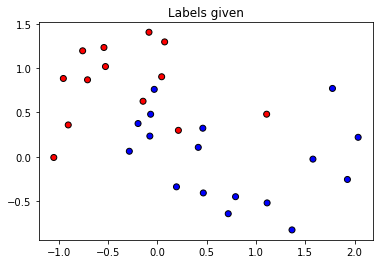

Optimizer for Euler-Lagrange equations
|   iter    |  target   |   sigma   |    tau    |
-------------------------------------------------
|  1        | -0.4183   |  0.4172   |  2.161    |
|  2        | -3.891    |  0.001114 |  0.9077   |
|  3        | -0.248    |  0.1475   |  0.2779   |
|  4        | -0.5164   |  0.1096   |  1.107    |
|  5        | -0.6039   |  0.8293   |  1.981    |
|  6        | -0.544    |  0.15     |  1.887    |
|  7        | -1.638    |  0.0869   |  2.276    |
|  8        | -0.3258   |  0.3958   |  0.4852   |
|  9        | -0.6789   |  0.8869   |  1.342    |
|  10       | -0.2217   |  0.4324   |  1.057    |
|  11       | -0.4362   |  0.6097   |  1.179    |
|  12       | -0.5365   |  0.5531   |  2.106    |
|  13       | -0.7583   |  0.1491   |  1.221    |
{'sigma': 0.4324295806529213, 'tau': 1.0567068433380202}
Optimizer for Newton's Method
|   iter    |  target   |   sigma   |    tau    |
-------------------------------------------------
|  1        | -0.2996   

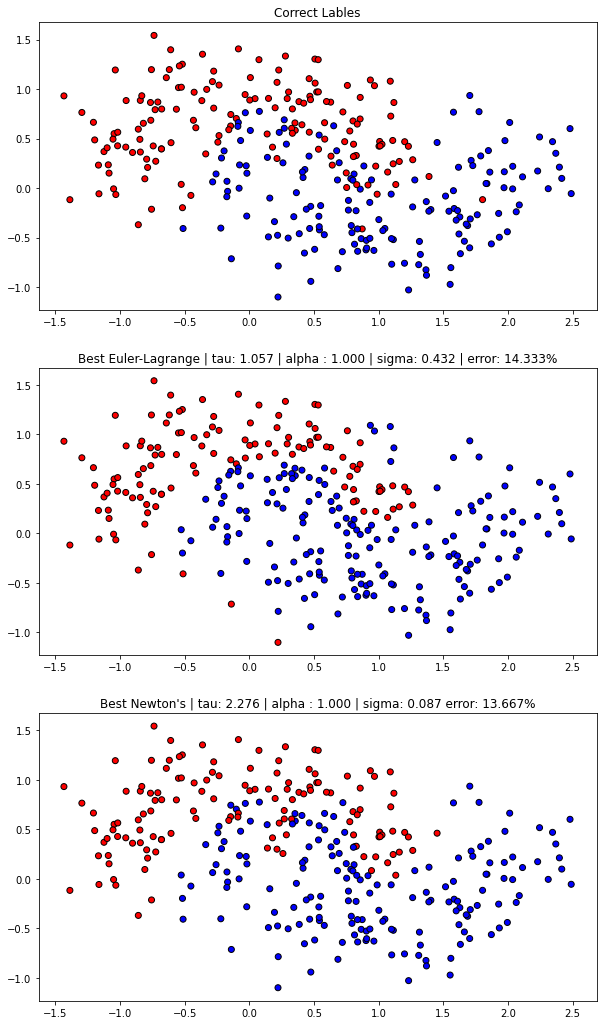

In [7]:
from sklearn.datasets import make_moons, make_circles
zeros = 1e-3

# Make Moons Data-set
N = 300
Data, y = make_moons(N, noise=0.3)
y[y==0] = -1
u_dagger = y
Z_prime = np.random.choice(N, int(N/10), replace=False)
pbounds = {'sigma': (zeros,1.0-zeros), 'tau':(zeros,3)}
results(Data, y, N, Z_prime, pbounds)

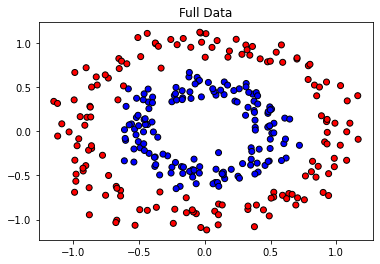

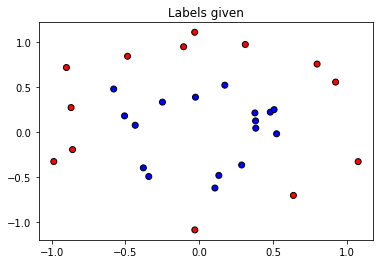

Optimizer for Euler-Lagrange equations
|   iter    |  target   |   sigma   |    tau    |
-------------------------------------------------
|  1        | -0.2179   |  0.4187   |  2.164    |
|  2        | -2.382    |  0.01011  |  0.914    |
|  3        | -0.5857   |  0.1538   |  0.2861   |
|  4        | -0.2361   |  0.1166   |  1.113    |
|  5        | -0.3571   |  0.8234   |  1.984    |
|  6        | -0.5301   |  0.1563   |  1.89     |
|  7        | -0.3525   |  0.09435  |  2.278    |
|  8        | -0.3932   |  0.3977   |  0.4928   |
|  9        | -0.3742   |  0.8799   |  1.347    |
|  10       | -0.5637   |  0.4336   |  1.063    |
|  11       | -0.4361   |  0.6077   |  1.185    |
|  12       | -0.3304   |  0.5521   |  2.109    |
|  13       | -0.4116   |  0.1555   |  1.226    |
{'sigma': 0.4186815646085225, 'tau': 2.1637702353920525}
Optimizer for Newton's Method
|   iter    |  target   |   sigma   |    tau    |
-------------------------------------------------
|  1        | -0.236    

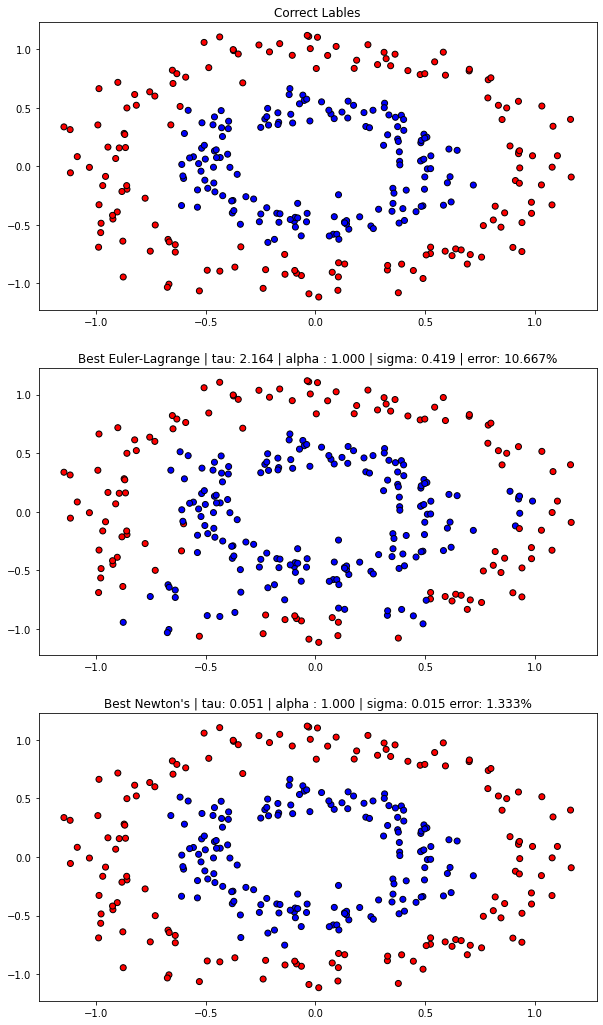

In [10]:
# Two-Circles Data Set
N = 300
zeros = 1e-2
Data, y = make_circles(N, factor=0.5, noise=0.1)
y[y==0] = -1
u_dagger = y
Z_prime = np.random.choice(N, int(N/10), replace=False)
pbounds = {'sigma': (zeros,1.0-zeros), 'tau':(zeros,3)}

results(Data, y, N, Z_prime, pbounds)